In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from Big_Cats import Test_Cats, Train_Cats

In [2]:
def display_img(img,label):
    print(f"Label : {training_data.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [4]:
batch_size = 32
num_data = 1600
learning_rate = 0.05
big_cats_train = '../CNN_Big_Cats/Big_Cats/Train_Cats'
big_cats_test = '../CNN_Big_Cats/Big_Cats/Test_Cats'

training_data = ImageFolder(big_cats_train, transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.RandomRotation(30), 
    transforms.ColorJitter(brightness=0.15, contrast=0.05, saturation=0.05, hue=0)]))

testing_data = ImageFolder(big_cats_test, transform = transforms.Compose([
    transforms.Resize((128, 128)), transforms.ToTensor()]))


train_size = len(training_data) - num_data



#For both datasets, each image is reszied to 150x150 pixels then converted to a tensor.
train_split, val_split = random_split(training_data, [train_size, num_data])


dload_train = DataLoader(train_split, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
dload_test = DataLoader(val_split, batch_size*2, num_workers = 4, pin_memory=True)
n_total_steps = len(dload_train)



print(f"Training data length: {len(train_split)}")
print(f"Training data length: {len(val_split)}")



Training data length: 200
Training data length: 1600


Image Size: torch.Size([3, 128, 128])
Which, means the image has 3 colour channels,and a length and width of 128 pixels. it has also been randomly
rotated and adjusted for brightness, hue, saturaton and potentially flipped as per our transformations.
Label : cheetah


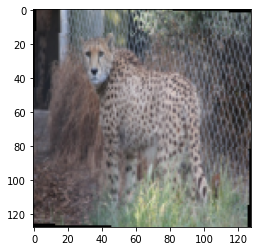

In [5]:
image, label = training_data[0]
print("Image Size: " + str(image.shape) + "\n" +"Which, means the image has 3 colour channels,\
and a length and width of 128 pixels. it has also been randomly" + "\n" +"rotated and adjusted \
for brightness, hue, saturaton and potentially flipped as per our transformations.")

display_img(image, label)



In [6]:
classes = ["hyena", 'cheetah']

print(len(classes))

2


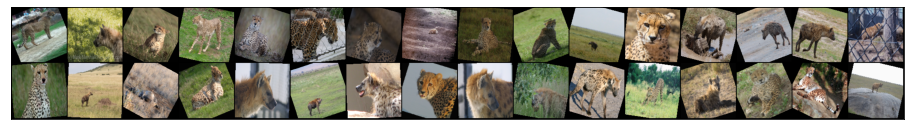

In [7]:
show_batch(dload_train)

In [8]:
# Here is where I shaped the network's layers through experimenting with
# gradually manipulating the image size through pooling and convolution.  

dataiter = iter(dload_train)
images, labels = dataiter.next()


conv1 = nn.Conv2d(3, 30, 5)
pool = nn.MaxPool2d(2, 2, padding=1)
conv2 = nn.Conv2d(30, 15, 5)

print(images.shape)

x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)

x = conv2(x)
print(x.shape)

x = pool(x)
print(x.shape)



torch.Size([32, 3, 128, 128])
torch.Size([32, 30, 124, 124])
torch.Size([32, 30, 63, 63])
torch.Size([32, 15, 59, 59])
torch.Size([32, 15, 30, 30])


C:\Users\TruAccount\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, 5)
        self.pool = nn.MaxPool2d(4, 4, padding=1)
        self.conv2 = nn.Conv2d(30, 15, 5)
        self.fc1 = nn.Linear(15*7*7, 100) #5*14*14 because our convolving filter and pooling decrease the img size.
        self.fc2 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.5)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 15*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
    
model = CNN().to(device)

In [10]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_size = len(training_data) - num_data
num_epochs = 200
losses = []
test_accuracies = []
train_accuracies = []

In [19]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dload_train):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 7 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            losses.append(loss.item())
            train_accuracies.append(check_accuracy(dload_train, model).numpy())
            
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)
#loss 0.69 -> 0.001

Epoch [1/200], Step [7/7], Loss: 0.7000
Epoch [2/200], Step [7/7], Loss: 0.7066
Epoch [3/200], Step [7/7], Loss: 0.6905
Epoch [4/200], Step [7/7], Loss: 0.6930
Epoch [5/200], Step [7/7], Loss: 0.6966
Epoch [6/200], Step [7/7], Loss: 0.6970
Epoch [7/200], Step [7/7], Loss: 0.6963
Epoch [8/200], Step [7/7], Loss: 0.6937
Epoch [9/200], Step [7/7], Loss: 0.6947
Epoch [10/200], Step [7/7], Loss: 0.6863
Epoch [11/200], Step [7/7], Loss: 0.6900
Epoch [12/200], Step [7/7], Loss: 0.6826
Epoch [13/200], Step [7/7], Loss: 0.6913
Epoch [14/200], Step [7/7], Loss: 0.7060
Epoch [15/200], Step [7/7], Loss: 0.6956
Epoch [16/200], Step [7/7], Loss: 0.6761
Epoch [17/200], Step [7/7], Loss: 0.6783
Epoch [18/200], Step [7/7], Loss: 0.6899
Epoch [19/200], Step [7/7], Loss: 0.6654
Epoch [20/200], Step [7/7], Loss: 0.6947
Epoch [21/200], Step [7/7], Loss: 0.6984
Epoch [22/200], Step [7/7], Loss: 0.6848
Epoch [23/200], Step [7/7], Loss: 0.6879
Epoch [24/200], Step [7/7], Loss: 0.7057
Epoch [25/200], Step [7/7

Epoch [199/200], Step [7/7], Loss: 0.4428
Epoch [200/200], Step [7/7], Loss: 0.9828
Finished Training


In [20]:
print(losses)
print(train_accuracies)

[0.6999531984329224, 0.7065636515617371, 0.69049471616745, 0.6930407285690308, 0.6965595483779907, 0.6970223188400269, 0.6963365077972412, 0.6936524510383606, 0.6947184205055237, 0.6863459944725037, 0.6899803876876831, 0.6825729012489319, 0.6913235783576965, 0.7060357928276062, 0.6955721378326416, 0.6761477589607239, 0.6783488392829895, 0.6898804903030396, 0.6653875708580017, 0.6947351694107056, 0.6983848810195923, 0.6848491430282593, 0.6878833174705505, 0.7057256698608398, 0.6941055655479431, 0.689814031124115, 0.7087963819503784, 0.6916877627372742, 0.6552425622940063, 0.647248387336731, 0.665472686290741, 0.6887961626052856, 0.7149055600166321, 0.681789755821228, 0.7055871486663818, 0.6456198692321777, 0.7202246189117432, 0.5560935735702515, 0.6803337335586548, 0.6812600493431091, 0.692838728427887, 0.5792702436447144, 0.6146019697189331, 0.7083847522735596, 0.7106779217720032, 0.6435970067977905, 0.5286362767219543, 0.7050042152404785, 0.7452371120452881, 0.6240103840827942, 0.5976

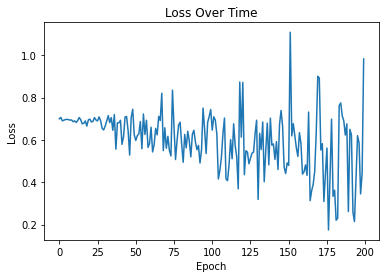

In [21]:

plt.title("Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.show()

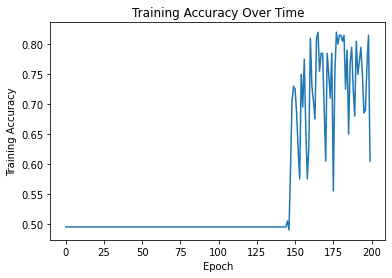

In [22]:
plt.title("Training Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(train_accuracies)
plt.show()

In [23]:
print(f"Accuracy on training set: {check_accuracy(dload_train, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(dload_test, model)*100:.2f}")

Accuracy on training set: 60.50
Accuracy on test set: 57.06
